In [2]:
from sklearn.datasets import fetch_openml
# La descarga de el dataset de sklearn se guarda por default en el directorio de usuario como 'scikit_learn_data'

mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape
y.shape

(70000,)

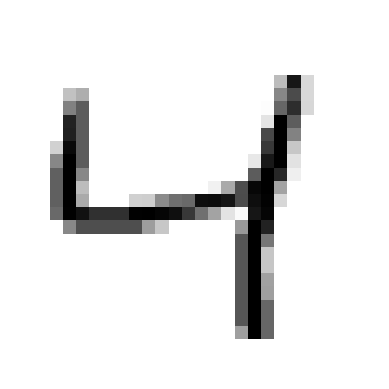

In [4]:
import matplotlib.pyplot as plt

#The images are 28x28 pixels
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[2]
plot_digit(some_digit)
plt.show()

In [5]:
# The labels are strings by default and usually as a 1D Numpy array
print(y[2])

4


In [6]:
# For convenience, split the data into a training set and a test set
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
# Create the target vectors for "is 4" classification
y_train_4 = (y_train == '4')
y_test_4 = (y_test == '4')

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_4)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [9]:
sgd_clf.predict([X[2]])

array([ True])

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, x_train, y_train_4, cv=3, scoring="accuracy")

array([0.9671 , 0.97645, 0.9687 ])

In [11]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(x_train, y_train_4)
print(any(dummy_clf.predict(x_train)))

False


In [12]:
cross_val_score(dummy_clf, x_train, y_train_4, cv=3, scoring="accuracy")

array([0.90265, 0.90265, 0.9026 ])

In [13]:
# We will make our own cross-validation function with StratifiedKFold and clone to better understand how it works
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(x_train, y_train_4):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_4[train_index]
    x_test_fold = x_train[test_index]
    y_test_fold = y_train_4[test_index]

    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9787
0.97745
0.97375


In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_4, cv=3)

In [15]:
from sklearn. metrics import confusion_matrix
# Confusion matrix to evaluate the accuracy of a classification, the rows represent the actual classes and the columns represent the predicted classes
# True Positive: 1 predicted as 1
# True Negative: 0 predicted as 0
# False Positive: 0 predicted as 1
# False Negative: 1 predicted as 0
# For example, in a binary classification of detecting 4s:
#                   Predicted
#               |  not 4 |   4
#            ---------------------    
#         not 4 |   TN   |   FP
# Actual     ---------------------
#             4 |   FN   |   TP

cm = confusion_matrix(y_train_4, y_train_pred)
cm

array([[52957,  1201],
       [  554,  5288]])

In [16]:
# The precision and recall can be calculated from the confusion matrix
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)

y_train_perfect_predictions = y_train_4
cm_perfect = confusion_matrix(y_train_4, y_train_perfect_predictions)

In [17]:
# Sklearn has functions to calculate precision and recall, and other to compute classifier metrics
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_4, y_train_pred) # 5288 / (5288 + 1201)
recall_score(y_train_4, y_train_pred) # 5288 / (5288 + 554)

0.905169462512838

In [18]:
#The F1 score is the harmonic mean of precision and recall
from sklearn.metrics import f1_score

# We can calculate it manually
# TP/(TP + 0.5*(FP + FN))

f1_score(y_train_4, y_train_pred)

0.8576757764982564

In [19]:
y_scores = sgd_clf.decision_function([some_digit])
y_some_digit_pred = (y_scores > 0)
y_scores

array([3214.66574913])

In [20]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_4, cv=3, method="decision_function")

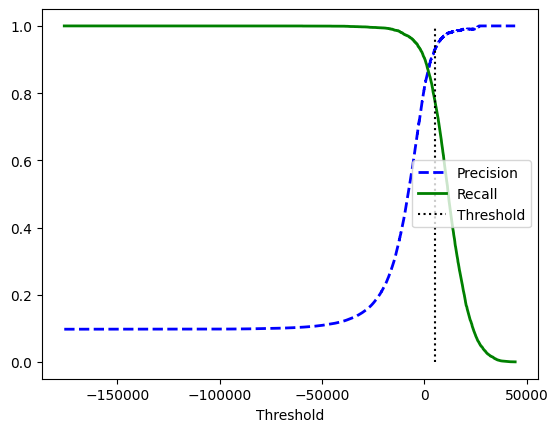

In [21]:
from sklearn.metrics import precision_recall_curve
threshold = 5000

precision, recall, thresholds = precision_recall_curve(y_train_4, y_scores)

plt.plot(thresholds, precision[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recall[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="Threshold")
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

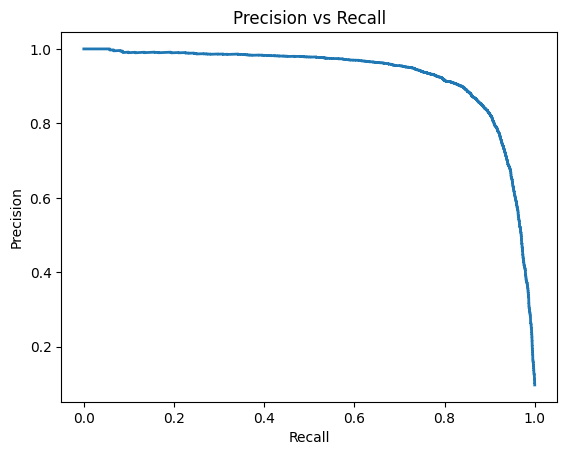

In [22]:
plt.plot(recall, precision, linewidth=2, label="Precision/Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall")
plt.show()

In [23]:
idx_for_90_precision = (precision >= 0.90).argmax()
threshold_90_precision = thresholds[idx_for_90_precision]

y_train_pred_90 = (y_scores >= threshold_90_precision)

print("Precision:", precision_score(y_train_4, y_train_pred_90))
print("Recall:", recall_score(y_train_4, y_train_pred_90))

Precision: 0.9001287474710318
Recall: 0.8377268058883944


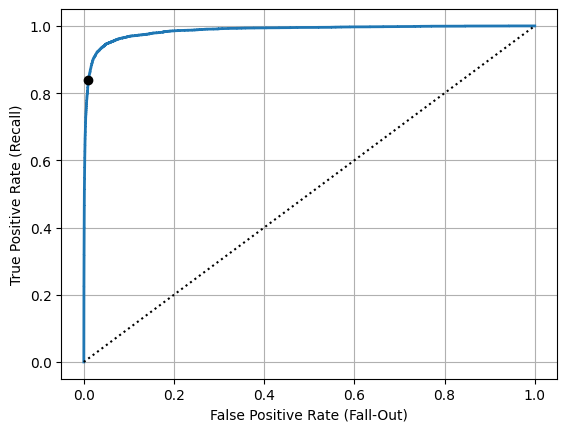

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_4, y_scores)

idx_for_threshold_at_90 = (thresholds <= threshold_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold at 90% precision")
plt.grid()
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()


In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_4, y_scores)

0.9859276923382874

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_4, cv=3, method="predict_proba")



In [27]:
y_probas_forest[:7]

array([[1.  , 0.  ],
       [1.  , 0.  ],
       [0.26, 0.74],
       [0.99, 0.01],
       [0.92, 0.08],
       [1.  , 0.  ],
       [1.  , 0.  ]])

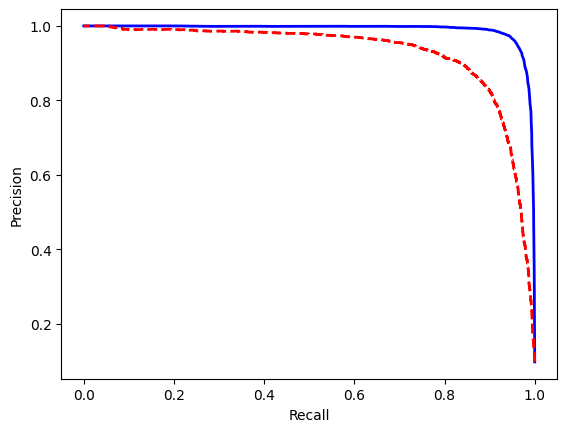

In [28]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_4, y_scores_forest)

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recall, precision, "r--", linewidth=2, label="SGD")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [29]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(x_train[:2000], y_train_4[:2000])

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [30]:
svm_clf.predict([some_digit])

array([ True])

In [31]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([1.])

In [32]:
class_id = some_digit_scores.argmax()
class_id

np.int64(0)

In [37]:
print('Opciones posibles: ', svm_clf.classes_)
svm_clf.classes_[class_id]

Opciones posibles:  [False  True]


np.False_

In [34]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(x_train[:2000], y_train[:2000])

,estimator,SVC(random_state=42)
,n_jobs,None
,verbose,0
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001


In [35]:
ovr_clf.predict([some_digit])

array(['4'], dtype='<U1')

In [36]:
len(ovr_clf.estimators_)

10

In [38]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train)   
sgd_clf.predict([some_digit])

array(['4'], dtype='<U1')

In [39]:
sgd_clf.decision_function([some_digit]).round(2)

array([[-34143.41, -21942.14,  -4018.29,  -2239.19,     43.09, -15058.88,
        -33653.31,  -8277.81,  -7460.52, -14180.15]])

In [40]:
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype("float64"))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

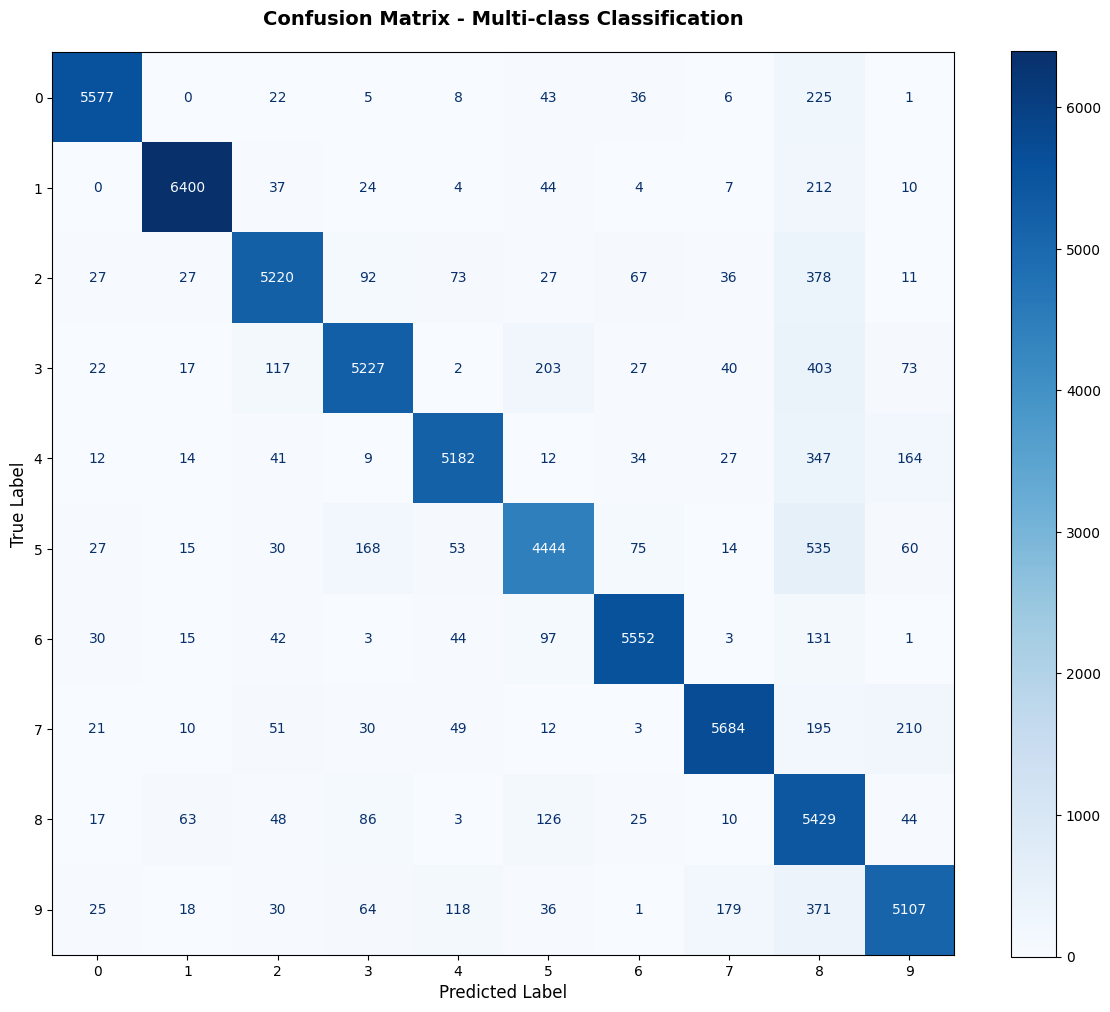

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, 
                                        ax=ax,
                                        cmap='Blues',
                                        values_format='d')
plt.title('Confusion Matrix - Multi-class Classification', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


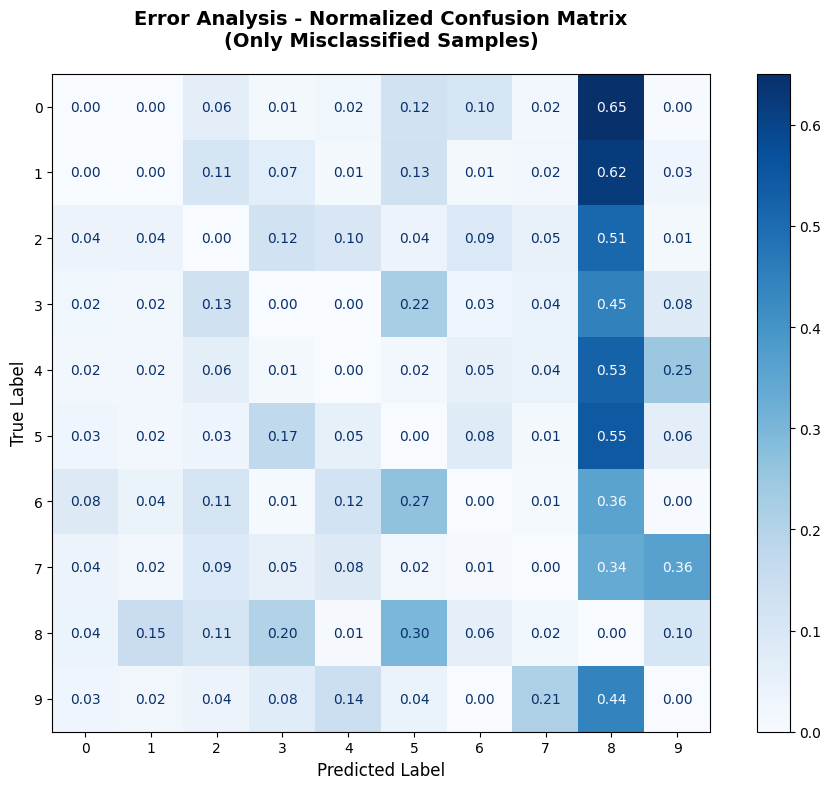

In [50]:
sample_weight = (y_train_pred != y_train)
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, 
                                        sample_weight=sample_weight, 
                                        normalize='true',
                                        ax=ax,
                                        cmap='Blues',
                                        values_format='.2f')
plt.title('Error Analysis - Normalized Confusion Matrix\n(Only Misclassified Samples)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [44]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [46]:
knn_clf.predict([some_digit])

array([[False, False]])

In [47]:
y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

In [48]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(x_train[:2000], y_multilabel[:2000])

chain_clf.predict([some_digit])

array([[0., 0.]])